In [16]:
import cv2
import mediapipe as mp
import numpy as np
import math
import matplotlib.pyplot as plt

In [11]:
# 두 node를 넣으면 벡터로 변환하여 리턴하는 함수
def makevector(pointA,pointB):
        #calculate vector between the two points (큰 노드에서 작은 노드로)
        vector = pointB-pointA
        return vector

# 두 vector data들의 cos 값 평균을 구하는 함수
def cos_sum(vectordata1, vectordata2):
    ls = [] #초기화
    for i in range(13):
        x = vectordata1[i]
        y = vectordata2[i]
        ls.append(check_degree(x,y))
        #print(check_degree(x,y))
        #cos = round(np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)),5)
        #ls.append( 1- (0.25*((cos+1)**2)) )  #0~1
              
    return sum(ls)/13

#두 벡터의 각도 차
def check_degree(i,j):
    x = np.dot(i,j ) / (np.linalg.norm(i) * np.linalg.norm(j))
    if x > 90:
        x = 90
    return math.degrees( math.acos( round(x,5) ))

In [12]:
# Loop over each frame of the video 
# 영상의 각 frame별 landmark들을 추출하여 리스트에 저장 (data1,data2)

def get_framedata(video_name): 

    # Load MediaPipe pose model
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose
    
    # Initialize the pose model
    pose1 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    # Open the video file
    sample1 = cv2.VideoCapture(video_name)

    framedata1 = [] #total video1 vector data by frame

    print("extracting vector...   video:",video_name)
    
    while True:
        # Read a frame from the video
        ret1, frame1 = sample1.read()
        
        if not ret1:
            print("complete!")
            break
        
        # Convert the frame from BGR to RGB
        frame1.flags.writeable = False
        image1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)  
        # Run the pose model on the frame
        results1 = pose1.process(image1)
        
        if not results1.pose_landmarks:
            continue
            
        landmark1 = []
        
        for i in range(33):
            if i>0 and i<11: # 1,2,3,4,5,6,7,8,9,10 점 제외
                continue
            elif i>16 and i<23: # 17,18,19,20,21,22 점 제외
                continue
            elif i>28 and i<33: # 29,30,31,32 점 제외
                continue
            
            marki = results1.pose_landmarks.landmark[i]
            landmark1 += [(marki.x,marki.y,marki.z)]
            
        landmark1 = np.array(landmark1)

        #13개의 vector를 저장하는 lists
        vectordata1 = [] # video 1의 것

        #landmark1에 들어있는 점들로 벡터 만들어서 vectordata에 저장 (13개)
        vectordata1.append( makevector((landmark1[1] + landmark1[2])/2, landmark1[0]) )
        vectordata1.append( makevector(landmark1[5], landmark1[3]) )
        vectordata1.append( makevector(landmark1[3], landmark1[1]) )
        vectordata1.append( makevector(landmark1[2], landmark1[1]) )
        vectordata1.append( makevector(landmark1[4], landmark1[2]) )
        vectordata1.append( makevector(landmark1[6], landmark1[4]) )
        vectordata1.append( makevector(landmark1[8], landmark1[2]) )
        vectordata1.append( makevector(landmark1[7], landmark1[1]) )
        vectordata1.append( makevector(landmark1[8], landmark1[7]) )
        vectordata1.append( makevector(landmark1[10], landmark1[8]) )
        vectordata1.append( makevector(landmark1[12], landmark1[10]) )
        vectordata1.append( makevector(landmark1[11], landmark1[9]) )
        vectordata1.append( makevector(landmark1[9], landmark1[7]) )
        
        framedata1+= [vectordata1]

        # Draw the pose skeleton on the frame
        # mp_drawing.draw_landmarks(frame1, results1.pose_landmarks, mp_pose.POSE_CONNECTIONS,
        #                           mp_drawing.DrawingSpec(color=(255, 0, 0)),
        #                          mp_drawing.DrawingSpec(color=(0, 255, 0)))
        
        # mp_drawing.draw_landmarks(frame2, results2.pose_landmarks, mp_pose.POSE_CONNECTIONS,
        #                           mp_drawing.DrawingSpec(color=(255, 0, 0)),
        #                           mp_drawing.DrawingSpec(color=(0, 255, 0)))
        # Resize the frame
        # resized_frame1 = cv2.resize(frame1,(width1//4,height1//4))
        # resized_frame2 = cv2.resize(frame2,(width2//4,height2//4))

        # Show the frame
        # cv2.imshow("Video1", resized_frame1)
        # cv2.imshow("Video2", resized_frame2)
        
        # Wait for the user to press 'q' to exit
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break
        
    # Release the video file and close the window
    sample1.release()
    return framedata1

extracting vector...   video: sample1.mp4
complete!
extracting vector...   video: sample3.mp4
complete!


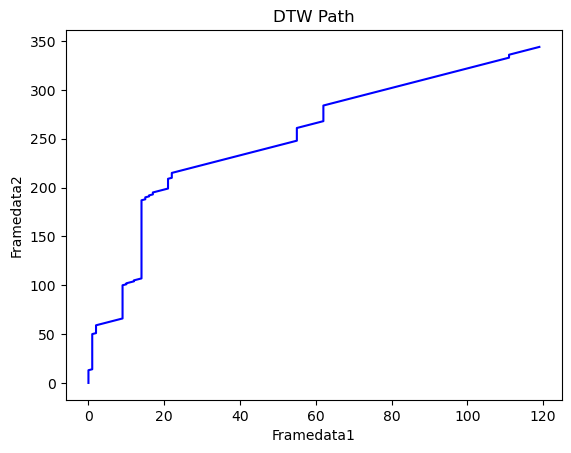

dtw path length: 345




similarity: 56.756 %


In [18]:
from fastdtw import fastdtw

framedata1 = get_framedata("sample1.mp4")
framedata2 = get_framedata("sample3.mp4")

dist_func = cos_sum
distance, path = fastdtw(framedata1, framedata2, dist= dist_func)

plt.plot([point[0] for point in path], [point[1] for point in path], 'b-')
plt.xlabel('Framedata1')
plt.ylabel('Framedata2')
plt.title('DTW Path')
plt.show()
print("dtw path length:", len(path))
print("\n\n\n")
print("similarity:",round(100- (distance/len(path))/90*100,3),"%")

In [44]:
pose_connection = frozenset({#(0, 33),   #어떤 landmark 끼리 연결할지에 대한 정보
           #(12, 33),
           #(11, 33),
           (1,2),
           (3, 5),
           (1, 3),
           (2, 4),
           (4, 6),
           (2, 8),
           (1, 7),
           (7, 8),
           (7, 9),
           (9, 11),
           (8, 10),
           (10, 12),
           })

In [45]:
# Load MediaPipe pose model
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Initialize the pose model
pose1 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
pose2 = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
# Open the video file
sample1 = cv2.VideoCapture("sample1.mp4")
sample2 = cv2.VideoCapture("sample4.mp4")

for i in range(20): #20번 째 frame 보기
    # Read a frame from the video
    ret1, frame1 = sample1.read()
    ret2, frame2 = sample2.read()

    if not ret1 or not ret2:
        break


# Convert the frame from BGR to RGB
image1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

# Run the pose model on the frame
results1 = pose1.process(image1)
results2 = pose2.process(image2)

width1 = int(sample1.get(cv2.CAP_PROP_FRAME_WIDTH))
height1 = int(sample1.get(cv2.CAP_PROP_FRAME_HEIGHT))

width2 = int(sample2.get(cv2.CAP_PROP_FRAME_WIDTH))
height2 = int(sample2.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Draw the pose skeleton on the frame
# a = results1.pose_landmarks.landmark
# b = landmark_pb2.NormalizedLandmark
# b.x= (a[11].x + a[12].x) /2
# b.y= (a[11].y + a[12].y) /2
# b.z= (a[11].z + a[12].z) /2
# c = landmark_pb2.NormalizedLandmark()

# results1.pose_landmarks.landmark.append(c)

# a = results2.pose_landmarks.landmark
# b = landmark_pb2.NormalizedLandmark
# b.x= (a[11].x + a[12].x) /2
# b.y= (a[11].y + a[12].y) /2
# b.z= (a[11].z + a[12].z) /2
# d = landmark_pb2.NormalizedLandmark()

del results1.pose_landmarks.landmark[1:11] #delete unused landmarks
del results2.pose_landmarks.landmark[1:11]

del results1.pose_landmarks.landmark[7:13]
del results2.pose_landmarks.landmark[7:13]

del results1.pose_landmarks.landmark[13:17]
del results2.pose_landmarks.landmark[13:17]

#del results1.pose_landmarks.landmark[7:12]
#del results2.pose_landmarks.landmark[7:12]

mp_drawing.draw_landmarks(frame1, results1.pose_landmarks, pose_connection,
                            mp_drawing.DrawingSpec(color=(255, 0, 0)),
                            mp_drawing.DrawingSpec(color=(0, 255, 0)))

mp_drawing.draw_landmarks(frame2, results2.pose_landmarks, pose_connection,
                            mp_drawing.DrawingSpec(color=(255, 0, 0)),
                            mp_drawing.DrawingSpec(color=(0, 255, 0)))

#Resize the frame
resized_frame1 = cv2.resize(frame1,(width1//2,height1//2))
resized_frame2 = cv2.resize(frame2,(width2//2,height2//2))

# Show the frame
cv2.imshow("Video1", resized_frame1)
cv2.imshow("Video2", resized_frame2)

#Wait for the user to press 'q' to exit
cv2.waitKey()           # 키가 입력될 때 까지 대기      
cv2.destroyAllWindows()  # 창 모두 닫기

# Release the video file and close the window
sample1.release()
sample2.release()

In [5]:
from mediapipe.framework.formats import landmark_pb2

a = landmark_pb2.NormalizedLandmark
print(a)
print(dir(a))

<class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmark'>
['ByteSize', 'Clear', 'ClearExtension', 'ClearField', 'CopyFrom', 'DESCRIPTOR', 'DiscardUnknownFields', 'FindInitializationErrors', 'FromString', 'HasExtension', 'HasField', 'IsInitialized', 'ListFields', 'MergeFrom', 'MergeFromString', 'PRESENCE_FIELD_NUMBER', 'ParseFromString', 'RegisterExtension', 'SerializePartialToString', 'SerializeToString', 'SetInParent', 'UnknownFields', 'VISIBILITY_FIELD_NUMBER', 'WhichOneof', 'X_FIELD_NUMBER', 'Y_FIELD_NUMBER', 'Z_FIELD_NUMBER', '_InternalParse', '_InternalSerialize', '_Modified', '_SetListener', '_UpdateOneofState', '__class__', '__deepcopy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__s

In [27]:
len(results1.pose_landmarks.landmark)

17